#Q-Learning for Maze Solving using PyTorch
This notebook demonstrates how to use Q-learning with a neural network (PyTorch) to solve a maze environment. We'll also visualize the learning process and the agent's performance using interactive plots and animations.

##Table of Contents
Setup and Installation

Maze Environment

Q-Network

Q-Learning Algorithm

Training the Agent

Visualizing Results

Animating the Solution

Conclusion

###By - Ishan Ambasta

In [9]:
# Install required libraries
!pip install gym numpy matplotlib torch tqdm

In [10]:
# Import libraries
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output, HTML
from tqdm import tqdm
import matplotlib.animation as animation

#Maze Environment
##We'll create a custom maze environment using gym. The maze is a 5x5 grid with obstacles, a start position, and a goal.

In [11]:
class MazeEnv(gym.Env):
    """
    Custom maze environment using gym.
    - The maze is a 5x5 grid.
    - The agent starts at the top-left corner (state 0).
    - The goal is at the bottom-right corner (state 24).
    - Obstacles are placed at specific states.
    """
    def __init__(self):
        super(MazeEnv, self).__init__()
        self.grid_size = 5
        self.action_space = gym.spaces.Discrete(4)  # 0: Up, 1: Down, 2: Left, 3: Right
        self.observation_space = gym.spaces.Discrete(self.grid_size * self.grid_size)
        self.state = 0  # Start state
        self.goal = self.grid_size * self.grid_size - 1  # Goal state
        self.obstacles = [6, 7, 12, 17]  # Obstacle states

    def reset(self):
        """Reset the environment to the start state."""
        self.state = 0
        return self.state

    def step(self, action):
        """
        Take a step in the environment.
        - action: 0 (Up), 1 (Down), 2 (Left), 3 (Right)
        - Returns: next_state, reward, done, info
        """
        x, y = self.state // self.grid_size, self.state % self.grid_size
        if action == 0:  # Up
            x = max(x - 1, 0)
        elif action == 1:  # Down
            x = min(x + 1, self.grid_size - 1)
        elif action == 2:  # Left
            y = max(y - 1, 0)
        elif action == 3:  # Right
            y = min(y + 1, self.grid_size - 1)

        new_state = x * self.grid_size + y
        if new_state in self.obstacles:  # Check for obstacles
            new_state = self.state

        self.state = new_state
        done = (self.state == self.goal)  # Check if goal is reached
        reward = 1 if done else -0.01  # Reward for reaching the goal
        return self.state, reward, done, {}

    def render(self):
        """Render the maze."""
        grid = np.zeros((self.grid_size, self.grid_size))
        grid[self.state // self.grid_size, self.state % self.grid_size] = 1  # Agent
        grid[self.goal // self.grid_size, self.goal % self.grid_size] = 2  # Goal
        for obs in self.obstacles:
            grid[obs // self.grid_size, obs % self.grid_size] = -1  # Obstacles
        print(grid)

#Q-Network
## We'll use a neural network to approximate the Q-values. The network takes the state as input and outputs Q-values for each action.

In [12]:
class QNetwork(nn.Module):
    """
    Neural network to approximate Q-values.
    - Input: State (one-hot encoded)
    - Output: Q-values for each action
    """
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)  # Fully connected layer 1
        self.fc2 = nn.Linear(64, 64)          # Fully connected layer 2
        self.fc3 = nn.Linear(64, action_size) # Output layer

    def forward(self, x):
        """Forward pass through the network."""
        x = torch.relu(self.fc1(x))  # Activation function
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

#Q-Learning Algorithm
##We'll implement the Q-learning algorithm using the Q-network. The agent learns by interacting with the environment and updating the Q-values.

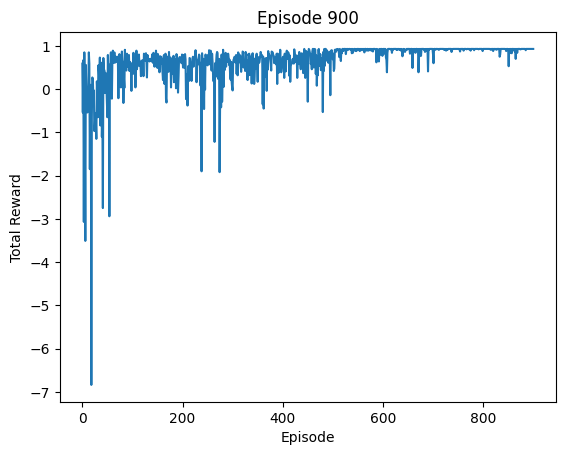

100%|██████████| 1000/1000 [00:50<00:00, 19.78it/s]

Training completed.


In [13]:
# Hyperparameters
state_size = 25  # 5x5 grid
action_size = 4  # 4 possible actions
learning_rate = 0.001
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 1000  # Number of training episodes

# Initialize environment and Q-network
env = MazeEnv()
q_network = QNetwork(state_size, action_size)
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
criterion = nn.MSELoss()  # Loss function

# Training loop
rewards = []  # Store rewards for each episode
epsilons = []  # Store epsilon values for each episode

for episode in tqdm(range(episodes)):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(np.eye(state_size)[state])
                q_values = q_network(state_tensor)
                action = torch.argmax(q_values).item()  # Exploit

        # Take action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # Update Q-values
        next_state_tensor = torch.FloatTensor(np.eye(state_size)[next_state])
        current_q_value = q_network(torch.FloatTensor(np.eye(state_size)[state]))[action]
        next_q_value = torch.max(q_network(next_state_tensor)).item()
        target_q_value = reward + gamma * next_q_value

        # Compute loss and update the network
        loss = criterion(current_q_value, torch.tensor(target_q_value))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards.append(total_reward)
    epsilons.append(epsilon)

    # Plot progress every 100 episodes
    if episode % 100 == 0:
        clear_output(wait=True)
        plt.plot(rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title(f'Episode {episode}')
        plt.show()

print("Training completed.")

#Visualizing Results
##Let's plot the learning curve and epsilon decay to analyze the agent's performance.

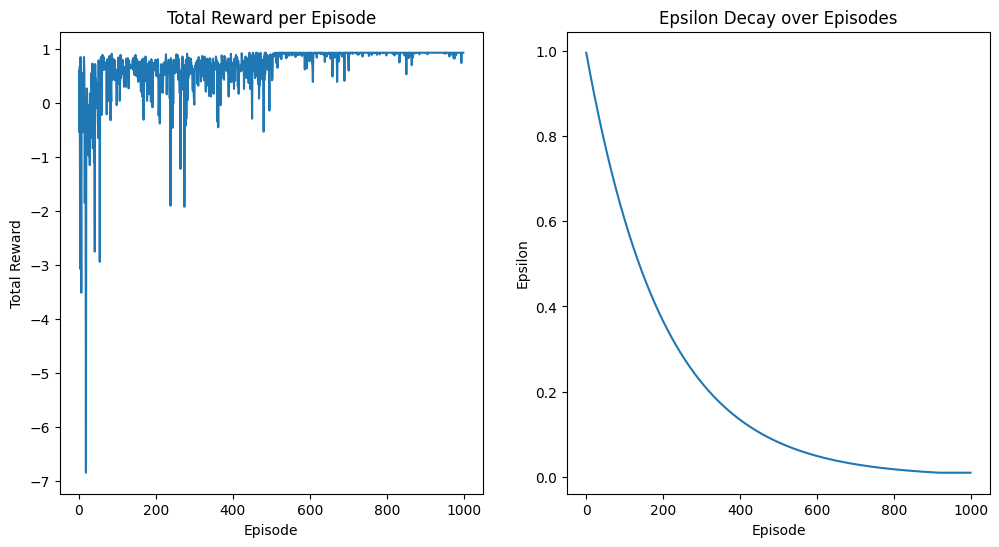

In [14]:
# Plot rewards and epsilon decay
plt.figure(figsize=(12, 6))

# Plot rewards
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')

# Plot epsilon decay
plt.subplot(1, 2, 2)
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay over Episodes')

plt.show()

# Animating the Solution
##Let's create an animation of the agent solving the maze after training.

In [15]:
# Simulate the agent's path
def simulate_agent_path(env, q_network, state_size):
    state = env.reset()
    done = False
    path = [state]
    while not done:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(np.eye(state_size)[state])
            q_values = q_network(state_tensor)
            action = torch.argmax(q_values).item()
        next_state, _, done, _ = env.step(action)
        path.append(next_state)
        state = next_state
    return path

# Render the maze at a given state
def render_maze(env, state):
    grid = np.zeros((env.grid_size, env.grid_size))
    grid[state // env.grid_size, state % env.grid_size] = 1  # Agent
    grid[env.goal // env.grid_size, env.goal % env.grid_size] = 2  # Goal
    for obs in env.obstacles:
        grid[obs // env.grid_size, obs % env.grid_size] = -1  # Obstacles
    return grid

# Create animation
def create_animation(env, q_network, state_size):
    path = simulate_agent_path(env, q_network, state_size)
    fig, ax = plt.subplots()
    ims = []

    for state in path:
        grid = render_maze(env, state)
        im = ax.imshow(grid, cmap='viridis', animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
    plt.close()
    return ani

# Display animation
ani = create_animation(env, q_network, state_size)
HTML(ani.to_jshtml())

#Conclusion
##The agent successfully learns to solve the maze! You can experiment with different hyperparameters, maze layouts, and neural network architectures to further improve performance.